--
title: "Poderosa combinação: Catboost com Conformal Prediction para análise de risco de crédito"
date: "02/24/2023"
categories: [Modelagem de Crédito, Machine Learning]
image: banner_post.png
description: Entenda os principais conceitos na modelagem de risco de crédito. E saiba como ela pode ser otimizada com machine learning!
---

In [ ]:
import pandas as pd
import numpy as np

# Machine Learning
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier

# Metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import  precision_recall_curve, roc_curve, roc_auc_score, average_precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib_venn import venn2, venn3

primary_color = '#6938d4'
analog_color = '#3855d4'
analog_color2= '#b738d4'
sec_color = '#a3d438'

error_color = '#C62828'

tria_color = '#d438a3'
tria_color2 = '#d46938'

In [2]:
from bcb import sgs
from bcb import Expectativas, sgs
from plotly.subplots import make_subplots
import pandas as pd
import plotly
import plotly.graph_objects as go
import plotly.express as px
from datetime import datetime
import plotly.io as plt_io

# create our custom_dark theme from the plotly_dark template
plt_io.templates["custom_dark"] = plt_io.templates["plotly_dark"]

# set the paper_bgcolor and the plot_bgcolor to a new color
plt_io.templates["custom_dark"]['layout']['paper_bgcolor'] = '#111111'
plt_io.templates["custom_dark"]['layout']['plot_bgcolor'] = '#111111'
#plt_io.templates["custom_dark"]['layout']['font']['size'] = 12
color_pallet = ("#6A38D4",) + plt_io.templates["custom_dark"]['layout']['colorway']
plt_io.templates["custom_dark"]['layout']['colorway'] = color_pallet

plt_io.templates["custom_dark"]['layout']['title']['font']['color'] = '#A6A5A5'

# you may also want to change gridline colors if you are modifying background
plt_io.templates['custom_dark']['layout']['yaxis']['gridcolor'] = '#4A4A4A'
plt_io.templates['custom_dark']['layout']['xaxis']['gridcolor'] = '#4A4A4A'

plt_io.templates['custom_dark']['layout']['font']['color'] = '#A6A5A5'

custom_template = {
    "layout": go.Layout(
        font={
            #"family": "Open Sans",
            "size": 12,
            "color": "#707070",
        },
        title={
            "font": {
                #"family": "Open Sans",
                "size": 18,
                #"color": "#1f1f1f",
                "color": "#6A38D4",
            },
        },
        plot_bgcolor="#555050",
        paper_bgcolor="#555050",
        #plot_bgcolor="#FFFFFF",
        #paper_bgcolor="#FFFFFF",
        #colorway=["#6A38D4"] + px.colors.qualitative.G10
        colorway=["#9A6EF8"] + px.colors.qualitative.G10
    )
}

def format_title(title, subtitle=None, subtitle_font_size=14):
    title = f'<b>{title}</b>'
    if not subtitle:
        return title
    subtitle = f'<span style="font-size: {subtitle_font_size}px;">{subtitle}</span>'
    return f'{title}<br>{subtitle}'

def series_pct_format(series, prec=2):
  return series.apply(lambda x: '{0:.{pre}f}%'.format(x, pre=prec))

template = "plotly_dark"


##### Buscando os indicadores macroeconômicos do Bacen em python

In [ ]:
#| echo: true
# instale a lib do Bacen
!pip install python-bcb

In [7]:
#| echo: true
series = {
    # <descrição da série>: <código da série>
    'Endividamento familiar': 29037,
    'Inflação (IPCA)': 13522,
    'Taxa de Juros (CDI)': 4392,
    'Taxa de Desemprego': 24369,
}

# Carregando as variáveis
df = sgs.get(series, start='2021-01-01')

Acesse o sistema de séries temporais do BACEN para consultar as definições dessas séries: [aqui](https://www4.bcb.gov.br/pec/series/port/aviso.asp?frame=1)

In [4]:
df_p = df.reset_index()
df_p = df_p.melt(value_vars=df.columns, id_vars=['Date'],
                 var_name="indicator",
                 value_name="value")
df_p = df_p[df_p.Date <= '2022-10-01']

##
##### Plot dos Indicadores macroeconômicos

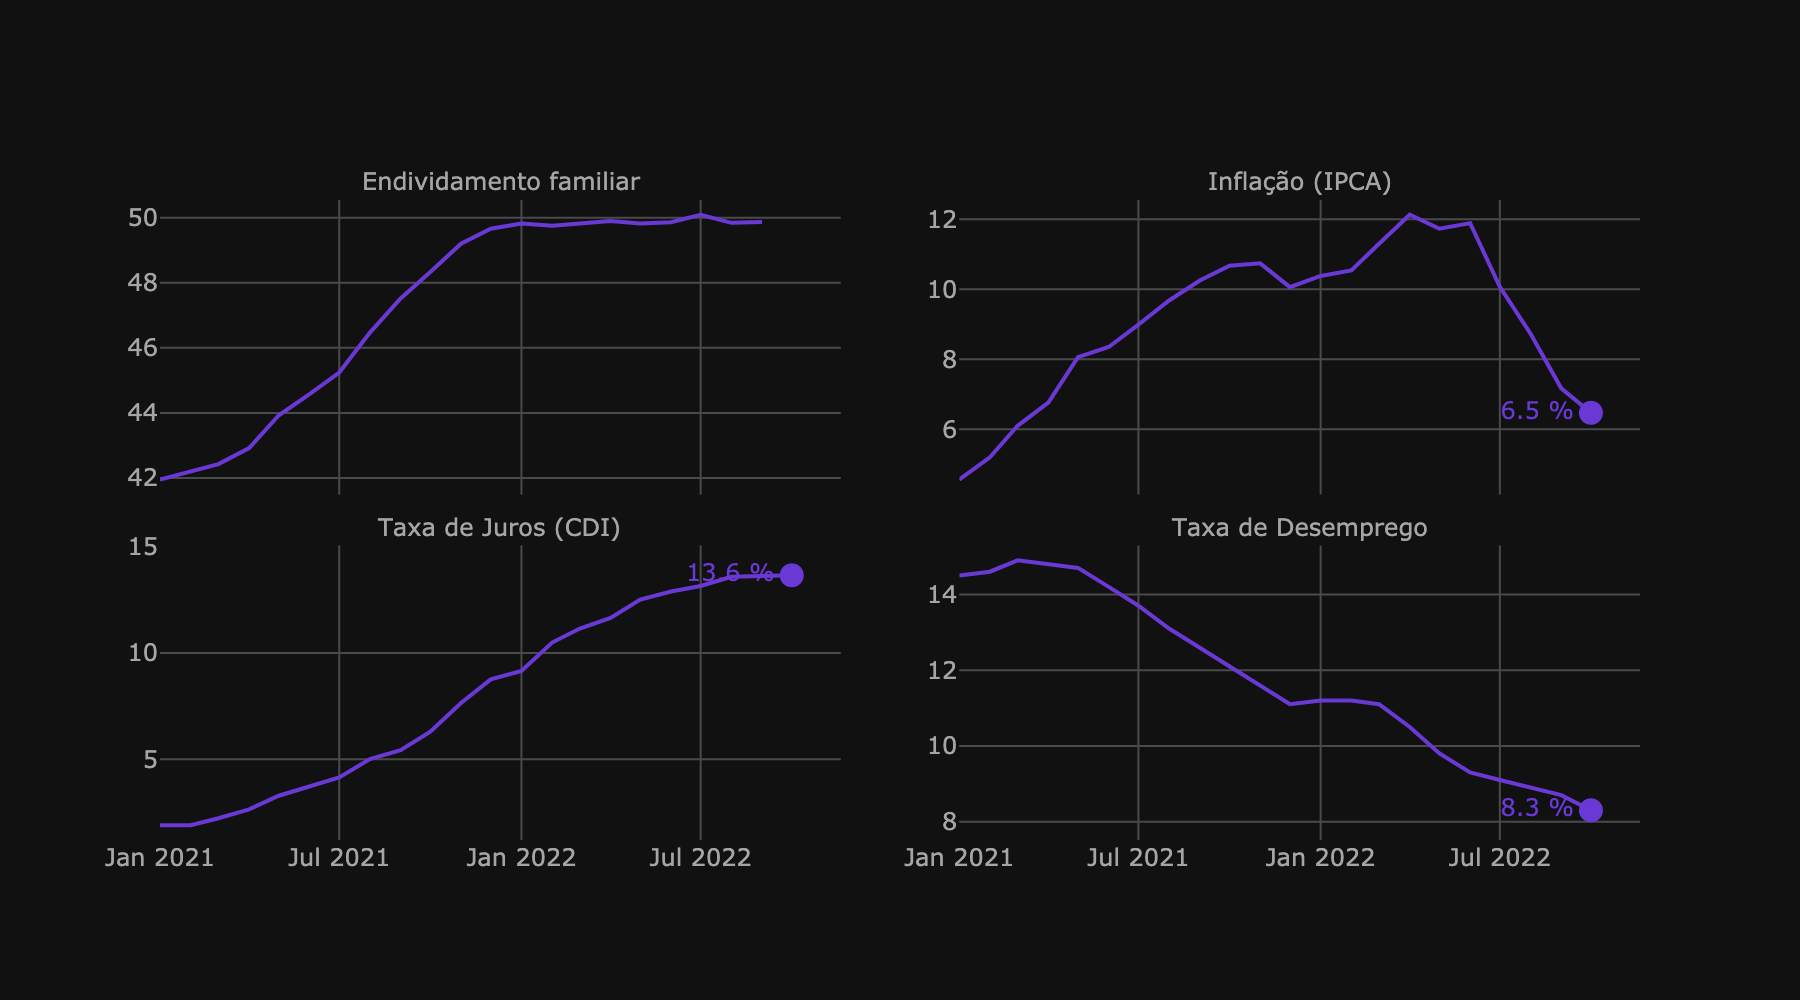

In [5]:
def series_pct_format(series, prec=2):
    return series.apply(lambda x: '{0:.{pre}f}%'.format(x, pre=prec))

fig = px.line(df_p, x='Date', y="value", title=format_title("", ''),
              template='custom_dark', height=500, width=900,
              facet_col="indicator", facet_col_wrap=2,
              facet_row_spacing=0.08,
              facet_col_spacing=0.08,
              )
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[1]))
fig.update_xaxes(title='')
fig.update_yaxes(title='')
fig = fig.update_yaxes(matches=None, showticklabels=True)
#fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
#fig.update_traces(textposition='top center')
#fig.update_layout(yaxis_range=[1.6, 2.4])
#fig.for_each_trace(
#    lambda trace: trace.update(marker_symbol="square") if trace.y ==  else (),
#)

#fig.add_vline(df_p.Date.max(), row=1,col=1)

#fig.add_annotation(2, x=df_p.Date.max(), row=1,col=1)
#fig.add_trace(go.Scatter(...), row='all', col='all', exclude_empty_subplots=True)
#fig.add_annotation
#fig.fo
#fig.update_traces(textposition='top center')
# add traces for annotations and text for end of lines
for i, d in enumerate(fig.data):
    row    = (2+1) - int(i / 2 + 1)
    column = int(i % 2 + 1)
    #print('i:', i, 'd:', d)
    fig.add_scatter(x=[d.x[-1]], y = [d.y[-1]],
                    mode = 'markers+text',
                    text = str(round(d.y[-1],1)) + ' %',
                    textfont = dict(color=d.line.color),
                    #textfont = dict(color=d.line.color),
                    textposition='middle left',
                    marker = dict(color = d.line.color, size = 12),
                    legendgroup = d.name,
                    showlegend=False, row=row,col=column)

#fig.show()
img_bytes = fig.to_image(format="png", scale=2)
from IPython.display import Image
Image(img_bytes)